In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from atom3d.datasets import load_dataset
from collapse.utils import deserialize
import os
import shutil

In [ ]:
klifs = pd.read_csv('data/KLIFS_quality6_res3.5.csv')

In [ ]:
klifs['pdb_chain'] = klifs['PDB'] + klifs['CHAIN']
klifs

,NAME,FAMILY,GROUPS,PDB,CHAIN,ALTERNATE_MODEL,SPECIES,LIGAND,PDB_IDENTIFIER,ALLOSTERIC_NAME,ALLOSTERIC_PDB,DFG,AC_HELIX,pdb_chain
0,JAK3,JakA,TK,4i6q,A,-,Human,N-[(1S)-1-cyclopropylethyl]-2-phenoxy-5H-pyrro...,1DT,1-phenylurea,PHU,in,in,4i6qA
1,MAPK1 (Erk2),MAPK,CMGC,6g54,A,B,Human,N-{2-[(5-chloro-2-{[4-(4-methylpiperazin-1-yl)...,6H3,-,-,in,in,6g54A
2,MAPK1 (Erk2),MAPK,CMGC,6dmg,A,B,Human,ethyl N-{2-chloro-4-[5-(5-{[(1S)-1-(3-chloro-4...,EK6,-,-,in,in,6dmgA
3,MAP3K20 (ZAK),MLK,TKL,6juu,A,A,Human,"~{N}-[2,4-bis(fluoranyl)-3-[4-(3-methoxy-1~{H}...",C9R,-,-,in,out,6juuA
4,CSNK1D (CK1d),CK1,CK1,4kba,C,B,Human,9-[3-(4-fluorophenyl)-1-methyl-1H-pyrazol-4-yl...,1QM,-,-,in,in,4kbaC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12403,Epha4 (EphA4),Eph,TK,2y6o,A,B,Mouse,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,1N1,-,-,in,in,2y6oA
12404,Aak1 (AAK1),NAK,Other,7rj7,A,B,Mouse,2-[(1S)-1-amino-3-methylbutyl]-6-(pyridin-4-yl...,5P6,-,-,in,in,7rj7A
12405,Aak1 (AAK1),NAK,Other,7rj8,A,A,Mouse,"N-[3-(difluoromethoxy)-4-(1,3-oxazol-5-yl)phen...",5QI,-,-,in,in,7rj8A
12406,Aak1 (AAK1),NAK,Other,7rj6,A,B,Mouse,5-[(4-aminopiperidin-1-yl)methyl]-N-{3-[5-(pro...,YFV,-,-,in,in,7rj6A


In [ ]:
pdb_str = ','.join(klifs['PDB'].tolist())
url = f'https://klifs.net/api_v2/structures_pdb_list?pdb-codes={pdb_str}'
json = requests.get(url).json()

In [ ]:
metadata = []
for item in json:
    item['pdb_chain'] = item['pdb'] + item['chain']
    metadata.append(item)
metadata = pd.DataFrame(metadata)

In [ ]:
klifs_meta = pd.merge(klifs, metadata, on='pdb_chain')

In [ ]:
pocket_indices = []
pocket_resnums = []
for id in tqdm(klifs_meta['structure_ID']):
    url = f'https://klifs.net/api_v2/interactions_match_residues?structure_ID={id}'
    residues = requests.get(url).json()
    idx = [r['index'] for r in residues]
    resnum = [r['Xray_position'] for r in residues]
    pocket_indices.append(idx)
    pocket_resnums.append(resnum)

100%|██████████| 22160/22160 [3:22:22<00:00,  1.83it/s]   


In [ ]:
id_list = ','.join([str(x) for x in klifs_meta['structure_ID'].tolist()])

In [ ]:
ifps = []
for id in tqdm(klifs_meta['structure_ID']):
    url = f'https://klifs.net/api_v2/interactions_get_IFP?structure_ID={id}'
    dat = requests.get(url).json()
    try:
        ifps.append(dat[0]['IFP'])
    except:
        ifps.append(np.nan)

100%|██████████| 22160/22160 [3:18:47<00:00,  1.86it/s]  


In [ ]:
klifs_meta['pocket_ifp'] = ifps

In [ ]:
klifs_meta['pocket_indices'] = pocket_indices
klifs_meta['pocket_resnums'] = pocket_resnums

In [ ]:
klifs_meta.to_csv('data/KLIFS_quality6_res3.5_metadata_2.csv', index=False)

In [ ]:
out_dir = '/scratch/users/aderry/klifs/pdb'
os.makedirs(out_dir, exist_ok=True)
for pdbc in tqdm(klifs_meta.pdb_chain.unique()):
    fname = f'../pdb/localpdb/mirror/pdb/{pdbc[1:3]}/pdb{pdbc[:4]}.ent.gz'
    if not os.path.exists(fname):
        continue
    shutil.copy(fname, f'{out_dir}/{pdbc[:4]}.pdb.gz')

  0%|          | 0/8273 [00:00<?, ?it/s]

100%|██████████| 8273/8273 [04:35<00:00, 30.02it/s]


In [2]:
klifs_meta = pd.read_csv('data/KLIFS_quality6_res3.5_metadata_2.csv')

In [3]:
klifs_dataset = load_dataset('/scratch/users/aderry/klifs/pdb_lmdb_nohet', 'lmdb')
len(klifs_dataset)

5892

In [4]:
klifs_meta.head()

,NAME,FAMILY,GROUPS,PDB,CHAIN,ALTERNATE_MODEL,SPECIES,LIGAND,PDB_IDENTIFIER,ALLOSTERIC_NAME,...,bp_II_B,bp_III,bp_IV,bp_V,curation_flag,ligand_ID,allosteric_ligand_ID,pocket_indices,pocket_resnums,pocket_ifp
0,JAK3,JakA,TK,4i6q,A,-,Human,N-[(1S)-1-cyclopropylethyl]-2-phenoxy-5H-pyrro...,1DT,1-phenylurea,...,False,False,False,False,False,147,145,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['826', '827', '828', '829', '830', '831', '83...",0000000000000010000001000000000000000000000000...
1,MAPK1 (Erk2),MAPK,CMGC,6g54,A,B,Human,N-{2-[(5-chloro-2-{[4-(4-methylpiperazin-1-yl)...,6H3,-,...,False,False,False,False,False,2370,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['29', '30', '31', '32', '33', '34', '35', '36...",0000000000000010000001000000100000010000000000...
2,MAPK1 (Erk2),MAPK,CMGC,6g54,A,B,Human,N-{2-[(5-chloro-2-{[4-(4-methylpiperazin-1-yl)...,6H3,-,...,False,False,False,False,False,2370,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['29', '30', '31', '32', '33', '34', '35', '36...",0000000000000010000001000000100000010000000000...
3,MAPK1 (Erk2),MAPK,CMGC,6g54,A,A,Human,N-{2-[(5-chloro-2-{[4-(4-methylpiperazin-1-yl)...,6H3,-,...,False,False,False,False,False,2370,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['29', '30', '31', '32', '33', '34', '35', '36...",0000000000000010000001000000100000010000000000...
4,MAPK1 (Erk2),MAPK,CMGC,6g54,A,A,Human,N-{2-[(5-chloro-2-{[4-(4-methylpiperazin-1-yl)...,6H3,-,...,False,False,False,False,False,2370,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['29', '30', '31', '32', '33', '34', '35', '36...",0000000000000010000001000000100000010000000000...


In [5]:
columns = ['pdb', 'chain', 'resolution', 'ligand', 'lig_chain', 'ligand_resids', 'catalytic_resids', 'ec_number', 'ligand_resnum', 'length']
data = []
with open('../BioLiP/BioLiP.txt') as f:
    for line in f:
        pdb, chain, resolution, _, ligand, lig_chain, _, sites_pdbnum, sites_renum, catalytic_pdbnum, catalytic_renum, ec_number, _, _, _, _, _, _, _, ligand_resnum, seq = line.strip().split('\t')
        data.append([pdb, chain, resolution, ligand, lig_chain, sites_pdbnum.split(), catalytic_pdbnum.split(), ec_number, ligand_resnum, len(seq)])
biolip = pd.DataFrame(data, columns=columns)

In [6]:
biolip_subset = biolip[['pdb', 'chain', 'ligand', 'ligand_resnum']].drop_duplicates()
biolip_subset.columns = ['PDB', 'CHAIN', 'PDB_IDENTIFIER', 'PDB_resnum']

In [7]:
biolip_subset

,PDB,CHAIN,PDB_IDENTIFIER,PDB_resnum
0,101m,A,HEM,155
1,102m,A,HEM,155
2,103m,A,HEM,155
3,104m,A,HEM,155
4,105m,A,HEM,155
...,...,...,...,...
820318,9xim,C,MN,395
820319,9xim,C,MN,396
820320,9xim,D,XLS,397
820321,9xim,D,MN,395


In [8]:
klifs_resnums = pd.merge(klifs_meta[['kinase', 'PDB', 'CHAIN', 'PDB_IDENTIFIER']], biolip_subset, on = ['PDB', 'CHAIN', 'PDB_IDENTIFIER'], how='left')

In [9]:
klifs_ifp = klifs_meta.dropna(subset=['pocket_ifp']).reset_index(drop=True)

In [10]:
len(klifs_ifp)

18409

In [11]:
klifs_ifp = klifs_ifp.drop_duplicates(subset=['pdb_chain', 'kinase', 'ligand', 'pocket_resnums']).reset_index(drop=True)

In [10]:
len(klifs_ifp), klifs_ifp.pdb_chain.nunique()

(7313, 7206)

In [12]:
k = 50000
clusterer = deserialize(f'data/pdb100_cluster_fit_{k}.pkl')

In [182]:
pocket_seqs = []
idf = np.ones(k+1)
tfidf_mat = np.zeros((len(klifs_ifp), k+1))
kinases = []
families = []
groups = []
dfg = []
ifps = []
for r, row in tqdm(klifs_ifp.iterrows(), total=len(klifs_ifp)):
    pdb = row['PDB']
    chain = row['CHAIN']
    pocket_resnums = eval(row['pocket_resnums'])
    family = row['FAMILY']
    group = row['GROUPS']
    dfg_in = row['DFG_x'] == 'in'
    if f'{pdb}.pdb.gz' not in klifs_dataset.ids():
        continue
    pdbdata = klifs_dataset[klifs_dataset.ids_to_indices([f'{pdb}.pdb.gz'])[0]]
    chain_idx = np.array(pdbdata['chains']) == chain
    pdbdata_emb = pdbdata['embeddings'][chain_idx]
    pdbdata_resids = np.array(pdbdata['resids'])[chain_idx]
    
    pdb_resnums = np.array([x[1:] for x in pdbdata_resids])
    pocket_clusters = (np.ones(85)*k).astype(int)
    exit_flag = False
    for i, num in enumerate(pocket_resnums):
        if num == '_':
            continue
        emb = pdbdata_emb[np.where(pdb_resnums == num)[0]]
        if len(emb) == 0:
            exit_flag = True
            break
        pocket_clusters[i] = np.squeeze(clusterer.predict(emb))
    if exit_flag:
        continue
    pocket_seqs.append(pocket_clusters)
    np.add.at(tfidf_mat[r,:], pocket_clusters, 1)
    idf[pocket_clusters] += 1
    kinases.append(row['kinase'])
    families.append(family)
    groups.append(group)
    dfg.append(dfg_in)
    ifps.append([int(x) for x in row['pocket_ifp']])
    

pocket_seqs = np.stack(pocket_seqs)

tf = tfidf_mat / tfidf_mat.sum(1)[:,np.newaxis]
idf = np.log(float(len(klifs_meta)) / idf)
tf_idf = tf * idf[np.newaxis, :]
tf_idf = tf_idf[np.nonzero(tfidf_mat.sum(axis=1))[0],:]

pocket_seqs.shape, tf_idf.shape

  0%|          | 0/7313 [00:00<?, ?it/s]

100%|██████████| 7313/7313 [3:43:34<00:00,  1.83s/it]  
/tmp/ipykernel_105135/1335916799.py:48: RuntimeWarning: divide by zero encountered in divide
  tf = tfidf_mat / tfidf_mat.sum(1)[:,np.newaxis]
/tmp/ipykernel_105135/1335916799.py:48: RuntimeWarning: invalid value encountered in divide
  tf = tfidf_mat / tfidf_mat.sum(1)[:,np.newaxis]


((7198, 85), (7198, 50001))

In [18]:
tf_idf.sum(axis=1)

array([3.02444484, 2.91706449, 2.90949604, ..., 4.44718811, 3.54612472,
       4.17322494])

In [183]:
tf_idf_reduced = tf_idf[:,np.any(tf_idf != 0, axis=0)]
tf_idf_reduced.shape

(7198, 11180)

In [20]:
50001 - 11180

38821

In [184]:
from collapse.utils import serialize, deserialize
serialize({'COLLAPSE-TFIDF': tf_idf_reduced, 'KLIFS-IFP': ifps, 'cluster_seqs': pocket_seqs, 'kinases': kinases, 'families': families, 'groups': groups, 'dfg_in': dfg}, f'data/klifs_processed_k{k}.pkl')

In [13]:
k = 50000
data = deserialize(f'data/klifs_processed_k{k}.pkl')
tf_idf = data['COLLAPSE-TFIDF']
ifps = data['KLIFS-IFP']
pocket_seqs = np.stack(data['cluster_seqs']).astype(int)
kinases = data['kinases']
families = data['families']
groups = data['groups']
dfg = data['dfg_in']

In [15]:
col.Counter(dfg)

Counter({True: 16139, False: 2079})

In [14]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import plotly.express as px
import collections as col

In [34]:
tf_idf_in = tf_idf[dfg]
ifp_in = np.array(ifps)[dfg]
kinases_in = np.array(kinases)[dfg]
families_in = np.array(families)[dfg]
groups_in = np.array(groups)[dfg]

In [26]:
reducer = TSNE(n_components=2, init='pca', verbose=1, learning_rate='auto')
tsne_fit = reducer.fit_transform(tf_idf_in)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6315 samples in 0.053s...
[t-SNE] Computed neighbors for 6315 samples in 11.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6315
[t-SNE] Computed conditional probabilities for sample 2000 / 6315
[t-SNE] Computed conditional probabilities for sample 3000 / 6315
[t-SNE] Computed conditional probabilities for sample 4000 / 6315
[t-SNE] Computed conditional probabilities for sample 5000 / 6315
[t-SNE] Computed conditional probabilities for sample 6000 / 6315
[t-SNE] Computed conditional probabilities for sample 6315 / 6315
[t-SNE] Mean sigma: 0.124582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.129166
[t-SNE] KL divergence after 1000 iterations: 0.849540


In [27]:
tsne_df = pd.DataFrame(tsne_fit, columns=['tSNE 1', 'tSNE 2'])
tsne_df['kinase'] = kinases_in
tsne_df['family'] = families_in
tsne_df['group'] = groups_in
tsne_df['dfg'] = dfg_in

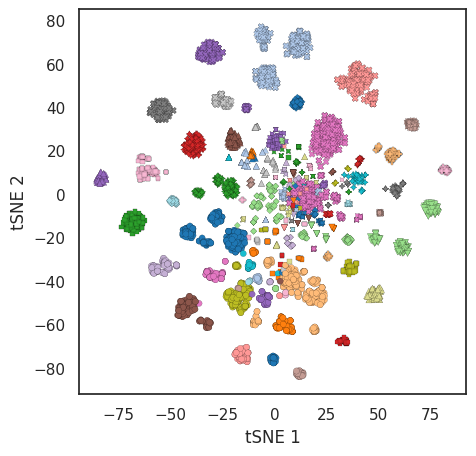

In [39]:
sns.set(style='white')
plt.figure(figsize=(5,5))
sns.scatterplot(tsne_df, x='tSNE 1', y='tSNE 2', hue='family', style='group', palette='tab20', edgecolor='black', linewidth=0.1, s=20)
plt.legend('', frameon=False)
plt.savefig('figures/klifs_collapse_tsne.svg', dpi=300, bbox_inches='tight', format='svg')

In [40]:
reducer = TSNE(n_components=2, init='pca', verbose=1, learning_rate='auto')
tsne_fit = reducer.fit_transform(ifp_in)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6315 samples in 0.002s...
[t-SNE] Computed neighbors for 6315 samples in 0.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6315
[t-SNE] Computed conditional probabilities for sample 2000 / 6315
[t-SNE] Computed conditional probabilities for sample 3000 / 6315
[t-SNE] Computed conditional probabilities for sample 4000 / 6315
[t-SNE] Computed conditional probabilities for sample 5000 / 6315
[t-SNE] Computed conditional probabilities for sample 6000 / 6315
[t-SNE] Computed conditional probabilities for sample 6315 / 6315
[t-SNE] Mean sigma: 0.984542
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.719856
[t-SNE] KL divergence after 1000 iterations: 1.528640


In [41]:
tsne_df = pd.DataFrame(tsne_fit, columns=['tSNE 1', 'tSNE 2'])
tsne_df['kinase'] = kinases_in
tsne_df['family'] = families_in
tsne_df['group'] = groups_in
tsne_df['dfg'] = dfg_in

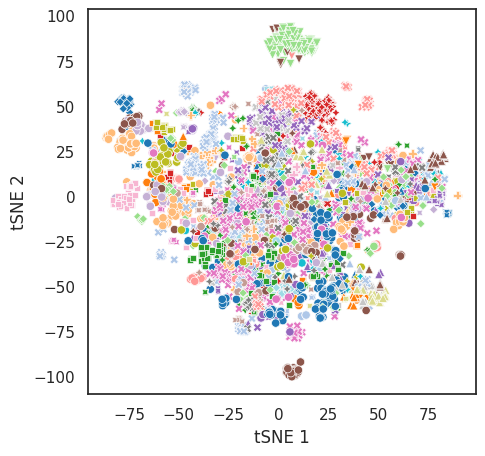

In [42]:
sns.set(style='white')
plt.figure(figsize=(5,5))
sns.scatterplot(tsne_df, x='tSNE 1', y='tSNE 2', hue='family', style='group', palette='tab20')
plt.legend('', frameon=False)
plt.savefig('figures/klifs_ifp_tsne.svg', dpi=300, bbox_inches='tight', format='svg')

In [43]:
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

In [ ]:
from sklearn.metrics.pairwise import safe_sparse_dot
distfn = lambda x,y: safe_sparse_dot(x, y.T, dense_output=True)

In [44]:
sample_sil_tfidf = silhouette_samples(tf_idf_in, families_in, metric='cosine')
sample_sil_ifp = silhouette_samples(ifp_in, families_in, metric='jaccard')

/oak/stanford/groups/rbaltman/aderry/miniconda3/envs/k2/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [45]:
sil_df = pd.DataFrame({'silhouette': sample_sil_tfidf.tolist() + sample_sil_ifp.tolist(), \
                       'fingerprint': ['COLLAPSE-cluster']*len(sample_sil_tfidf) + ['KLIFS-IFP']*len(sample_sil_ifp), \
                           'kinase': kinases_in.tolist() + kinases_in.tolist(), \
                           'family': families_in.tolist() + families_in.tolist(), \
                               'group': groups_in.tolist() + groups_in.tolist()})

In [47]:
kinase_to_group = dict(zip(klifs_meta['kinase'], klifs_meta['GROUPS']))
family_to_group = dict(zip(klifs_meta['FAMILY'], klifs_meta['GROUPS']))
group_colors = dict(zip(klifs_meta['GROUPS'].unique(), sns.color_palette('tab20')))

In [48]:
from matplotlib.patches import Patch

In [61]:
family_cts = dict(sil_df.value_counts('family'))
sil_df['family_ct'] = sil_df['family'].map(family_cts)
sil_df_ct5 = sil_df[sil_df['family_ct'] >= 5]

In [62]:
kinase_order = sil_df_ct5[sil_df_ct5.fingerprint == 'COLLAPSE-cluster'].groupby('family')['silhouette'].mean().sort_values(ascending=False).index.tolist()

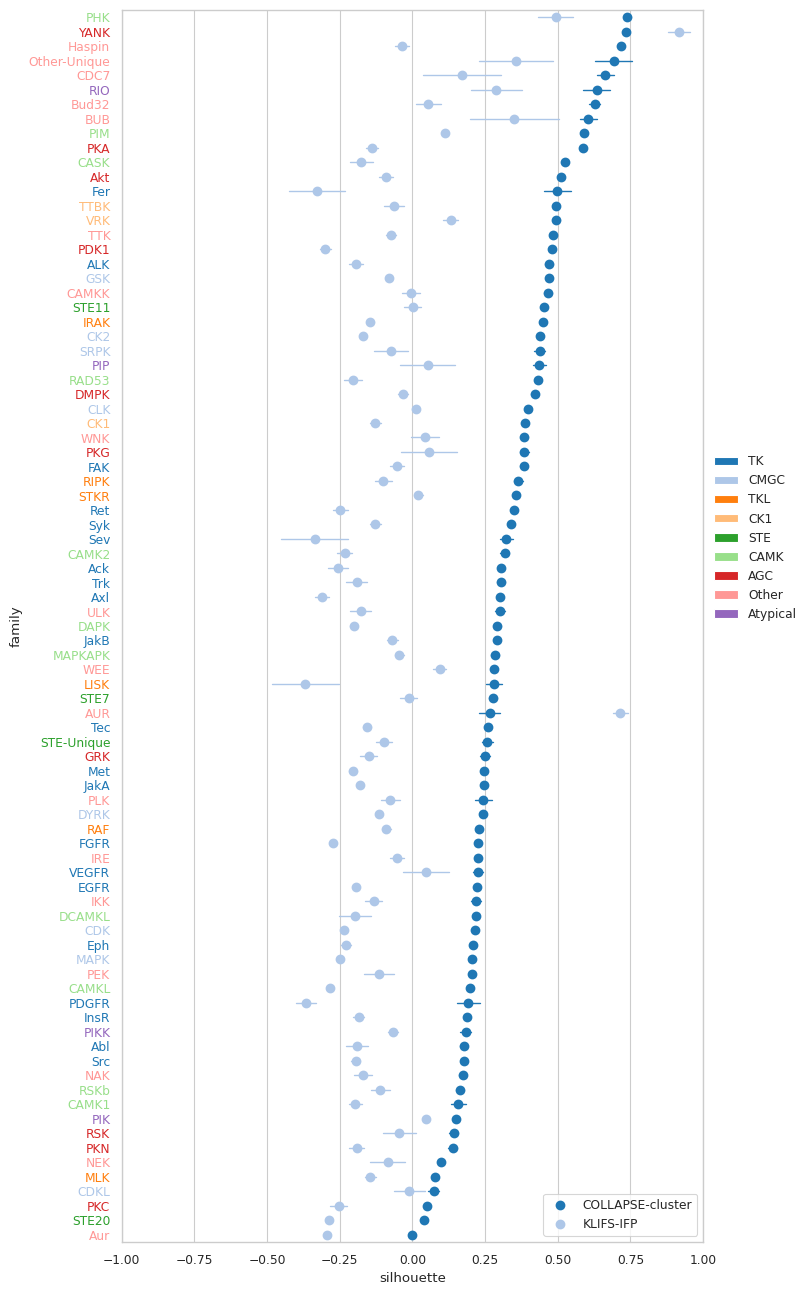

In [68]:
sns.set(context='paper', style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(7.5,16))
p = sns.pointplot(data=sil_df_ct5, x='silhouette', y='family', hue='fingerprint', orient='h', errorbar='se', err_kws={'linewidth': 1}, linestyle='none', palette='tab20', order=kinase_order, ax = ax)

first_legend = plt.legend(loc='lower right')

colors = [group_colors[(family_to_group[x])] for x in kinase_order]
for tick, color in zip(ax.get_yticklabels(), colors): tick.set_color(color)

legend_elements = [Patch(facecolor=sns.color_palette('tab20')[i], edgecolor='w',
                         label=klifs_meta['GROUPS'].unique()[i]) for i in range(len(group_colors))]

plt.legend(handles=legend_elements, loc=(1.01, 0.5), frameon=False)
plt.xlim(-1.0, 1.0)

# plt.legend(handles=[p], loc='upper left')
plt.gca().add_artist(first_legend)

plt.savefig('figures/klifs_silhouette_family.svg', bbox_inches='tight', dpi=300, format='svg')
plt.show()

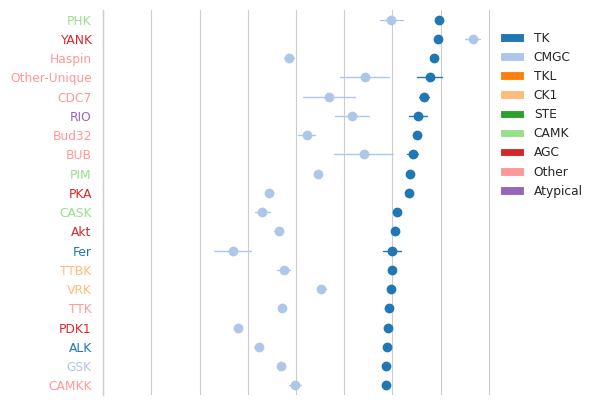

In [83]:
sns.set(context='paper', style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(5,5))
p = sns.pointplot(data=sil_df_ct5, x='silhouette', y='family', hue='fingerprint', orient='h', errorbar='se', err_kws={'linewidth': 1}, linestyle='none', palette='tab20', order=kinase_order[:20], ax = ax)

first_legend = plt.legend(loc='lower right')

colors = [group_colors[(family_to_group[x])] for x in kinase_order[:20]]
for tick, color in zip(ax.get_yticklabels(), colors): tick.set_color(color)

legend_elements = [Patch(facecolor=sns.color_palette('tab20')[i], edgecolor='w',
                         label=klifs_meta['GROUPS'].unique()[i]) for i in range(len(group_colors))]

plt.legend(handles=legend_elements, loc=(1.01, 0.5), frameon=False)
plt.xlim(-1.0, 1.01)
sns.despine(bottom=True)

ax.set_xticklabels([])
# ax.set_xticks([])
ax.set_xlabel(None)
ax.set_ylabel(None)

# plt.legend(handles=[p], loc='upper left')
# plt.gca().add_artist(first_legend)

plt.savefig('figures/klifs_silhouette_family_top20.svg', bbox_inches='tight', dpi=300, format='svg')
plt.show()

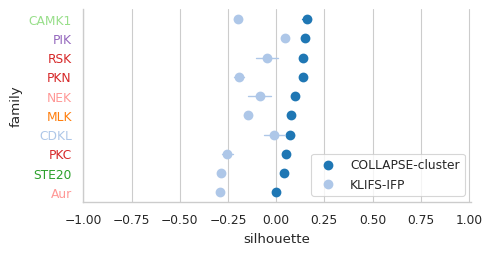

In [82]:
sns.set(context='paper', style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(5,2.5))
p = sns.pointplot(data=sil_df_ct5, x='silhouette', y='family', hue='fingerprint', orient='h', errorbar='se', err_kws={'linewidth': 1}, linestyle='none', palette='tab20', order=kinase_order[-10:], ax = ax)

first_legend = plt.legend(loc='lower right')

colors = [group_colors[(family_to_group[x])] for x in kinase_order[-10:]]
for tick, color in zip(ax.get_yticklabels(), colors): tick.set_color(color)

legend_elements = [Patch(facecolor=sns.color_palette('tab20')[i], edgecolor='w',
                         label=klifs_meta['GROUPS'].unique()[i]) for i in range(len(group_colors))]

# plt.legend(handles=legend_elements, loc=(1.01, 0.5), frameon=False)
plt.xlim(-1.0, 1.01)
sns.despine(top=True)
# plt.legend(handles=[p], loc='upper left')
# plt.gca().add_artist(first_legend)

plt.savefig('figures/klifs_silhouette_family_bottom10.svg', bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [84]:
from scipy.stats import wilcoxon
pvals = {} 
stats = {} 
collapse_means = {}
ifp_means = {}
collapse_sds = {}
ifp_sds = {}
k_cts = dict(sil_df.value_counts('family'))
for k, k_df in sil_df.groupby('family'):
    if k_cts[k] < 10:
        continue
    collapse_vals = k_df[k_df.fingerprint == 'COLLAPSE-cluster'].silhouette.tolist()
    ifp_vals = k_df[k_df.fingerprint == 'KLIFS-IFP'].silhouette.tolist()
    stat,pval = wilcoxon(collapse_vals, ifp_vals)
    pvals[k] = pval * (sil_df.value_counts('family') >= 10).sum()
    stats[k] = stat
    collapse_means[k] = np.mean(collapse_vals) 
    ifp_means[k] = np.mean(ifp_vals)
    collapse_sds[k] = np.std(collapse_vals) 
    ifp_sds[k] = np.std(ifp_vals)

In [85]:
kinase_pvals = pd.DataFrame([pvals, stats, collapse_means, collapse_sds, ifp_means, ifp_sds]).T
kinase_pvals.columns = ['pval', 'wilcoxon', 'COLLAPSE-mean', 'COLLAPSE-std', 'KLIFS-IFP-mean', 'KLIFS-IFP-std']
kinase_pvals['direction'] = kinase_pvals['COLLAPSE-mean'] > kinase_pvals['KLIFS-IFP-mean']
# print(f'{len(kinase_pvals[kinase_pvals < 0.05])} of {len(kinase_pvals)} kinases with at least 10 structures are significant')

In [86]:
collapse_greater = np.sum((kinase_pvals.pval < 0.05) & (kinase_pvals.direction == True))
ifp_greater = np.sum((kinase_pvals.pval < 0.05) & (kinase_pvals.direction == False))
total = len(kinase_pvals)

In [87]:
print(f'COLLAPSE-cluster better for {collapse_greater} of {total} kinases')
print(f'KLIFS-IFP better for {ifp_greater} of {total} kinases')

COLLAPSE-cluster better for 63 of 80 kinases
KLIFS-IFP better for 0 of 80 kinases


In [88]:
kinase_pvals

,pval,wilcoxon,COLLAPSE-mean,COLLAPSE-std,KLIFS-IFP-mean,KLIFS-IFP-std,direction
ALK,9.094947e-12,0.0,0.469534,0.083867,-0.193636,0.152104,True
AUR,5.000000e+00,0.0,0.265199,0.073916,0.715174,0.050460,False
Abl,1.525879e-04,0.0,0.177184,0.052424,-0.190834,0.167154,True
Ack,4.882812e-03,0.0,0.305879,0.038924,-0.256629,0.129097,True
Akt,7.450581e-08,0.0,0.511932,0.051125,-0.090585,0.129805,True
...,...,...,...,...,...,...,...
ULK,4.768372e-06,0.0,0.300894,0.079788,-0.178367,0.179155,True
VRK,2.273737e-12,0.0,0.494417,0.080799,0.131691,0.169090,True
WEE,1.164153e-08,3.0,0.281042,0.048138,0.093227,0.124440,True
WNK,7.812500e-02,0.0,0.385453,0.043246,0.041848,0.152608,True


## Kinase Profiling

In [15]:
from sklearn.metrics import pairwise_distances

In [16]:
import json
with open("data/karaman-profiling.js", "r") as f:
    json_string = f.read()
json_string_cleaned = json_string.replace("=", ": ").replace(";", ", ").replace("\n", "")
json_string_cleaned = json_string_cleaned.replace("karaman_compounds", "\"karaman_compounds\"")
json_string_cleaned = json_string_cleaned.replace("karaman_profiling", "\"karaman_profiling\"")
json_string_cleaned = json_string_cleaned[:-3] + "}"
karaman_dict = json.loads(json_string_cleaned)

karaman_df = {}
for ligand, measures in karaman_dict["karaman_profiling"].items():
    karaman_df[ligand] = {measure["xName"]: measure["Kd(nM)"] for measure in measures}
karaman_df = pd.DataFrame(karaman_df)
print(karaman_df.shape)
karaman_df.head()

(268, 30)


,Staurosporine,JNJ-7706621,MLN-8054,PKC-412,SU-14813,SB-202190,CP-724714,VX-680/MK-0457,Dasatinib,Roscovitine/CYC-202,...,ZD-6474,Sunitinib,Flavopiridol,Erlotinib,MLN-518,LY-333531,CI-1033,EKB-569,PI-103,PTK-787
AAK1,1.2,200.0,NaN,48.0,66.0,NaN,NaN,290.0,NaN,NaN,...,NaN,11.0,5300.0,1200.0,NaN,900.0,NaN,3500.0,NaN,NaN
ABL1,290.0,1200.0,820.0,NaN,1500.0,NaN,NaN,13.0,0.53,NaN,...,270.0,830.0,NaN,310.0,NaN,NaN,1400.0,560.0,NaN,NaN
ABL2,110.0,NaN,3300.0,NaN,NaN,NaN,NaN,4.0,0.17,NaN,...,69.0,1000.0,NaN,200.0,NaN,NaN,870.0,370.0,NaN,NaN
ALK2,470.0,5900.0,NaN,NaN,NaN,NaN,NaN,1900.0,620.00,NaN,...,150.0,NaN,1900.0,NaN,2500.0,NaN,1700.0,NaN,NaN,NaN
ALK4,680.0,NaN,NaN,NaN,NaN,950.0,NaN,NaN,330.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
klifs_resnums_karaman = klifs_resnums[klifs_resnums.kinase.isin(karaman_df.index)].drop_duplicates().dropna()
klifs_resnums_karaman['PDB'] = klifs_resnums_karaman['PDB'].str.upper()
klifs_resnums_karaman[['PDB', 'PDB_IDENTIFIER', 'PDB_resnum']].to_csv('data/karaman_pf_input.txt', sep='\t', index=False, header=False)

In [111]:
klifs_resnums_karaman_sample = klifs_resnums_karaman.groupby('kinase').sample(1)
klifs_resnums_karaman_sample[['PDB', 'PDB_IDENTIFIER', 'PDB_resnum']].to_csv('data/karaman_pf_input_sample1.txt', sep='\t', index=False, header=False)

In [18]:
id_to_kinase = dict(zip(klifs_resnums_karaman['PDB'] + '_' + klifs_resnums_karaman['PDB_IDENTIFIER'] + '_' + klifs_resnums_karaman['PDB_resnum'].str.strip(), klifs_resnums_karaman['kinase']))

In [ ]:
(~karaman_df.isna()).sum(axis=0)

Staurosporine          245
JNJ-7706621            131
MLN-8054                50
PKC-412                 96
SU-14813               148
SB-202190               41
CP-724714                6
VX-680/MK-0457         130
Dasatinib               84
Roscovitine/CYC-202     20
SB-203580               29
Gefitinib               33
CP-690550                7
Imatinib                27
GW-2580                  4
Lapatinib                5
GW-786034               72
Sorafenib               46
VX-745                  14
SB-431542               25
ZD-6474                 82
Sunitinib              163
Flavopiridol            68
Erlotinib               48
MLN-518                 18
LY-333531               52
CI-1033                 66
EKB-569                 86
PI-103                  59
PTK-787                  8
dtype: int64

In [53]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score
from scipy.stats import spearmanr

In [46]:
inhibitors= {'Erlotinib': ['EGFR'],
             'EKB-569': ['EGFR'],
            #  'Lapatinib': ['EGFR', 'ErbB2'],
            #  'Gefitinib': ['EGFR'],
            #  'Imatinib': ['ABL1', 'KIT', 'PDGFRb'],
             'Dasatinib': ['ABL1', 'SRC'],
             'Sunitinib': ['KIT', 'FLT3'],
             'VX-680/MK-0457': ['AurA', 'AurB', 'AurC'],
             'LY-333531': ['PKCb'],
            #  'Sorafenib': ['BRAF'],
             'GW-786034': ['FLT1', 'FLT4'],
             'PKC-412': ['FLT3', 'KIT'],
             'ZD-6474': ['EGFR', 'RET'],
             }

In [49]:
inhibitor_names = {
    'Erlotinib': 'Erlotinib',
    'EKB-569': 'Pelitinib',
    'Dasatinib': 'Dasatinib',
    'Sunitinib': 'Sunitinib',
    'VX-680/MK-0457': 'Tozasertib',
    'LY-333531': 'Ruboxistaurin',
    'GW-786034': 'Pazopanib',
    'PKC-412': 'Midostaurin',
    'ZD-6474': 'Vandetanib',
}

In [37]:
inh_counts = {}
for inh in karaman_df.columns:
    count = len(karaman_df[inh].dropna())
    inh_counts[inh] = count

In [38]:
inh_counts

{'Staurosporine': 245,
 'JNJ-7706621': 131,
 'MLN-8054': 50,
 'PKC-412': 96,
 'SU-14813': 148,
 'SB-202190': 41,
 'CP-724714': 6,
 'VX-680/MK-0457': 130,
 'Dasatinib': 84,
 'Roscovitine/CYC-202': 20,
 'SB-203580': 29,
 'Gefitinib': 33,
 'CP-690550': 7,
 'Imatinib': 27,
 'GW-2580': 4,
 'Lapatinib': 5,
 'GW-786034': 72,
 'Sorafenib': 46,
 'VX-745': 14,
 'SB-431542': 25,
 'ZD-6474': 82,
 'Sunitinib': 163,
 'Flavopiridol': 68,
 'Erlotinib': 48,
 'MLN-518': 18,
 'LY-333531': 52,
 'CI-1033': 66,
 'EKB-569': 86,
 'PI-103': 59,
 'PTK-787': 8}

In [58]:
metrics = []
for inhibitor, targets in inhibitors.items():
    print(inhibitor)
    ib = karaman_df[inhibitor].fillna(10000).sort_values()
    ib_profile_ = pd.DataFrame(ib).reset_index()
    ib_profile_.columns = ['kinase', 'Kd (nM)']
    ib_profile_['binding'] = ib_profile_['Kd (nM)'] < 100
    
    for target in targets:
        ib_profile = ib_profile_.copy()
        idx = np.where(np.array(kinases) == target)[0]
        if len(idx) == 0:
            continue
        ref_ifp = np.array(ifps)[idx]
        ref_tfidf = tf_idf[idx]
        ib_ifp = {}
        ib_tfidf = {}
        for kin in ib.index:
            if kin == target:
                continue
            kin_idx = np.where(np.array(kinases) == kin)[0]
            if len(kin_idx) == 0:
                continue
            kin_ifp = np.array(ifps)[kin_idx]
            kin_tfidf = tf_idf[kin_idx]
            ifp_dists = pairwise_distances(ref_ifp.astype(bool), kin_ifp.astype(bool), metric='jaccard')
            tfidf_dists = pairwise_distances(ref_tfidf, kin_tfidf, metric='cosine')

            ib_ifp[kin] = ifp_dists.min()
            ib_tfidf[kin] = tfidf_dists.min()
        
        ib_profile['KLIFS-IFP'] = ib_profile['kinase'].map(ib_ifp)
        ib_profile['COLLAPSE-cluster'] = ib_profile['kinase'].map(ib_tfidf)
        ib_profile = ib_profile.dropna(subset=['KLIFS-IFP', 'COLLAPSE-cluster'])
        
        auroc_ifp = roc_auc_score(ib_profile['binding'], 1 - ib_profile['KLIFS-IFP'])
        auroc_tfidf = roc_auc_score(ib_profile['binding'], 1 - ib_profile['COLLAPSE-cluster'])
        ap_ifp = average_precision_score(ib_profile['binding'], 1 - ib_profile['KLIFS-IFP'])
        ap_tfidf = average_precision_score(ib_profile['binding'], 1 - ib_profile['COLLAPSE-cluster'])

        metrics.append([inhibitor, target, 'KLIFS-IFP', 'AUROC', auroc_ifp])
        metrics.append([inhibitor, target, 'KLIFS-IFP', 'AP', ap_ifp])

        metrics.append([inhibitor, target, 'COLLAPSE-cluster', 'AUROC', auroc_tfidf])
        metrics.append([inhibitor, target, 'COLLAPSE-cluster', 'AP', ap_tfidf])


Erlotinib
EKB-569
Dasatinib
Sunitinib
VX-680/MK-0457
LY-333531
GW-786034
PKC-412
ZD-6474


In [59]:
metrics = pd.DataFrame(metrics, columns=['inhibitor', 'target', 'fingerprint', 'metric', 'value'])
metrics['inhibitor'] = metrics['inhibitor'].map(inhibitor_names)
metrics

,inhibitor,target,fingerprint,metric,value
0,Erlotinib,EGFR,KLIFS-IFP,AUROC,0.671296
1,Erlotinib,EGFR,KLIFS-IFP,AP,0.038837
2,Erlotinib,EGFR,COLLAPSE-cluster,AUROC,0.511111
3,Erlotinib,EGFR,COLLAPSE-cluster,AP,0.024572
4,Pelitinib,EGFR,KLIFS-IFP,AUROC,0.738128
5,Pelitinib,EGFR,KLIFS-IFP,AP,0.066525
6,Pelitinib,EGFR,COLLAPSE-cluster,AUROC,0.495810
7,Pelitinib,EGFR,COLLAPSE-cluster,AP,0.150116
8,Dasatinib,ABL1,KLIFS-IFP,AUROC,0.776316
9,Dasatinib,ABL1,KLIFS-IFP,AP,0.492334


/tmp/ipykernel_42953/1942282824.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=metrics[(metrics.metric == 'AP')], x='inhibitor', hue='fingerprint', y='value', palette='tab20', hue_order=['COLLAPSE-cluster', 'KLIFS-IFP'], errorbar='se', errwidth=1)


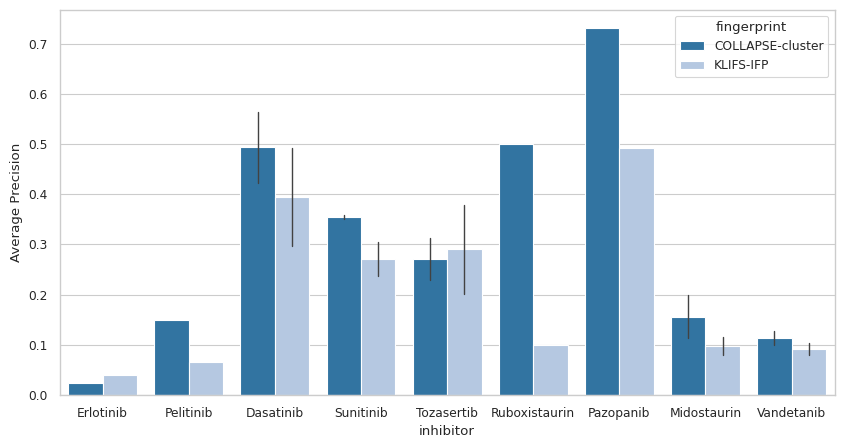

In [60]:
sns.set(context='paper', style='whitegrid')
plt.figure(figsize=(10,5))
sns.barplot(data=metrics[(metrics.metric == 'AP')], x='inhibitor', hue='fingerprint', y='value', palette='tab20', hue_order=['COLLAPSE-cluster', 'KLIFS-IFP'], errorbar='se', errwidth=1)
plt.ylabel('Average Precision')
plt.savefig('figures/karaman_AP.svg', bbox_inches='tight', dpi=300, format='svg')

/tmp/ipykernel_42953/3705617838.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(data=metrics[(metrics.metric == 'AUROC')], x='inhibitor', hue='fingerprint', y='value', palette='tab20', hue_order=['COLLAPSE-cluster', 'KLIFS-IFP'], errorbar='se', errwidth=1)


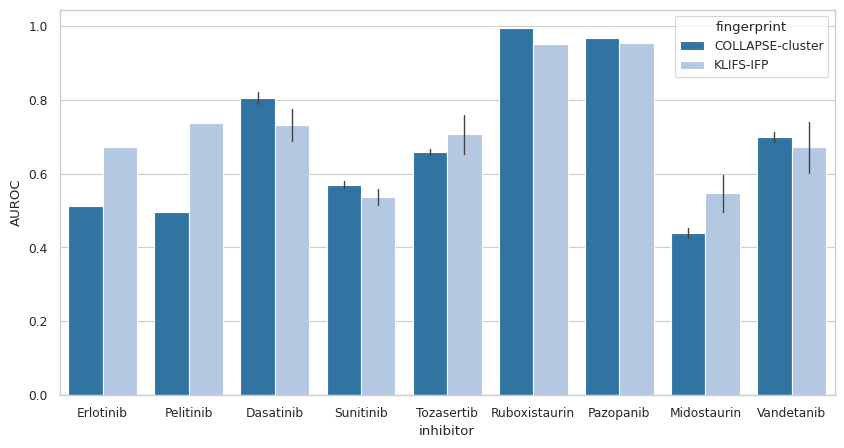

In [61]:
sns.set(context='paper', style='whitegrid')
plt.figure(figsize=(10,5))
sns.barplot(data=metrics[(metrics.metric == 'AUROC')], x='inhibitor', hue='fingerprint', y='value', palette='tab20', hue_order=['COLLAPSE-cluster', 'KLIFS-IFP'], errorbar='se', errwidth=1)
plt.ylabel('AUROC')
plt.savefig('figures/karaman_AUROC.svg', bbox_inches='tight', dpi=300, format='svg')

In [63]:
import scipy.stats
from sklearn.preprocessing import MinMaxScaler

In [67]:
corr_data = []
for inhibitor, targets in inhibitors.items():
    if inhibitor not in karaman_df.columns:
        continue
    print(inhibitor)
    inhibitor_name = inhibitor_names[inhibitor]
    ib = karaman_df[inhibitor].dropna().sort_values()
    ib_profile_ = pd.DataFrame(ib).reset_index()
    ib_profile_.columns = ['kinase', 'Kd (nM)']
    
    for target in targets:
        scatter_data = col.defaultdict(list)
        ib_profile = ib_profile_.copy()
        
        idx = np.where(np.array(kinases) == target)[0]
        if len(idx) == 0:
            continue
        ref_ifp = np.array(ifps)[idx]
        ref_tfidf = tf_idf[idx]
        ib_ifp = {}
        ib_tfidf = {}
        for kin in ib.index:
            if kin == target:
                continue
            kin_idx = np.where(np.array(kinases) == kin)[0]
            if len(kin_idx) == 0:
                continue
            kin_ifp = np.array(ifps)[kin_idx]
            kin_tfidf = tf_idf[kin_idx]
            ifp_dists = pairwise_distances(ref_ifp.astype(bool), kin_ifp.astype(bool), metric='jaccard')
            tfidf_dists = pairwise_distances(ref_tfidf, kin_tfidf, metric='cosine')

            ib_ifp[kin] = ifp_dists.min()
            ib_tfidf[kin] = tfidf_dists.min()

        ib_profile['KLIFS-IFP'] = ib_profile['kinase'].map(ib_ifp)
        ib_profile['COLLAPSE-cluster'] = ib_profile['kinase'].map(ib_tfidf)
        ib_profile = ib_profile.dropna(subset=['COLLAPSE-cluster'])
        ib_profile_ifp = ib_profile.dropna(subset=['KLIFS-IFP'])
        
        tfidf_norm = MinMaxScaler().fit_transform(ib_profile['COLLAPSE-cluster'].values.reshape(-1, 1))
        ifp_norm = MinMaxScaler().fit_transform(ib_profile_ifp['KLIFS-IFP'].values.reshape(-1, 1))
        
        scatter_data['kd'].extend(np.log10(ib_profile['Kd (nM)']).tolist())
        scatter_data['score'].extend(list(tfidf_norm.flatten()))
        scatter_data['method'].extend(['COLLAPSE-cluster']*len(ib_profile))
        r, p = scipy.stats.pearsonr(np.log10(ib_profile['Kd (nM)']).tolist(), list(tfidf_norm.flatten()))
        corr_data.append([inhibitor, target, 'COLLAPSE-cluster', r, p])
        
        scatter_data['kd'].extend(np.log10(ib_profile_ifp['Kd (nM)']).tolist())
        scatter_data['score'].extend(list(ifp_norm.flatten()))
        scatter_data['method'].extend(['KLIFS-IFP']*len(ib_profile_ifp))
        r, p = scipy.stats.pearsonr(np.log10(ib_profile_ifp['Kd (nM)']).tolist(), list(ifp_norm.flatten()))
        corr_data.append([inhibitor_name, target, 'KLIFS-IFP', r, p])
        
        scatter_data = pd.DataFrame(scatter_data)
        
        plt.clf()
        sns.set(context='paper', style='whitegrid')
        # plt.figure(figsize=(4,3))
        g = sns.lmplot(data=scatter_data, x='kd', y='score', hue='method', palette='tab20', aspect=1.2, height=3, legend=False)
        # g.map_dataframe(annotate)
        plt.title(f'{inhibitor_name} - {target}')
        plt.ylim(0,1.01)
        # plt.xlim(0,4.0)
        plt.xlabel('$log(K_d)$')
        plt.legend(loc=(1.01,0.8))
        plt.savefig(f'data/{inhibitor_name}_{target}_karaman_corr.svg', bbox_inches='tight', dpi=300, format='svg')
        plt.close()
        # plt.show()
corr_data = pd.DataFrame(corr_data, columns=['inhibitor', 'target', 'method', 'r', 'p'])
corr_data.to_csv('data/karaman_corr_data.csv', index=False)

Erlotinib
EKB-569
Dasatinib
Sunitinib
VX-680/MK-0457
LY-333531
GW-786034
PKC-412
ZD-6474


<Figure size 640x480 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>